In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import SymLogNorm, LogNorm
from astropy import units as u
from skimage import measure
from imutils import contours
import imutils
from astropy.table import Table
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve as ap_convolve
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '/Users/gianlucadituccio/Documents/Project'
data_path = path + '/data'

optimal_median_factor = 2.7
n_pixel = 10
font_size = 25

In [4]:
color = {
    '1' : 'plasma',
    '2' : 'gray',
    '3' : 'magma'
}
inp = input('Insert the color scale for images:\n(1 for "plasma")\n(2 for "gray")\n(3 for "magma")\n')
print('You choose the color: ', color.get(inp, -1))
color = color.get(inp, -1)

Insert the color scale for images:
(1 for "plasma")
(2 for "gray")
(3 for "magma")
3
You choose the color:  magma


In [5]:
coordinates_dataset = pd.read_csv('coordinates.csv')
model_selected = (57, 158, 340) # upload the model you want

In [6]:
base_url = data_path + '/model_sky{0:1d}.fits'
image_list = [base_url.format(n) for n in model_selected]
image_concat = [fits.open(image) for image in image_list]

In [7]:
def plot_histogram_image(image, fig, ax, title):
    ax.title.set_text(title)
    plt.ylim(500)
    return ax.hist(image.flatten(), bins='auto')

In [8]:
def gaussian_filtering(image):
    sigma = 4
    gauss_kernel = Gaussian2DKernel(sigma, x_size=(2*3*sigma+1), y_size=(2*3*sigma+1))
    gauss_image = ap_convolve(image, gauss_kernel, normalize_kernel=True)
    return gauss_image

In [9]:
def linear_mapping_values(image):
    r_max = np.amax(image)
    r_min = np.amin(image)
    s_min = 0
    s_max = 255
    # s = (s_max - s_min) / (r_max - r_min) * (r - r_min) + s_min
    x, y = image.shape
    for i in range(0,x):
        for j in range(0,y):
            image[i,j] = ((s_max - s_min) / (r_max - r_min)) * (image[i,j] - r_min) + s_min
    stretch = np.round(image, 0)
    return np.uint8(stretch)

In [10]:
def thresholding_image(image):
    return np.where(image >= np.median(image)*optimal_median_factor, 255, 0)      

In [11]:
def algorithm_and_plot(i, n_model, font_size):
    wcs = WCS(i[0].header)
    
    
    fig = plt.figure(figsize=(30,30)) 
    fig.subplots_adjust(wspace=0.02)
    fig.subplots_adjust(hspace=0.3)
    
    # plot of the original image
    ax = fig.add_subplot(3, 2, 1, projection=wcs)
    img = ax.imshow(i[0].data, norm=SymLogNorm(1), interpolation='gaussian', cmap=color)
    ax.coords[0].set_format_unit(u.deg)
    ax.coords[1].set_format_unit(u.deg)
    cb = plt.colorbar(img, ax=ax, shrink=0.6)
    ax.tick_params(axis='both', labelsize=font_size)
    cb.ax.tick_params(labelsize=font_size) 
    cb.set_label('counts', fontsize=font_size)
    ax.set_xlabel('right ascension (RA)', fontsize=font_size)
    ax.set_ylabel('declination (DEC)', fontsize=font_size)
    ax.set_title('Original Image', fontsize=font_size)
    ax.grid(color='grey', ls='solid')
    
    
    # apply gaussian
    gaussian_image = gaussian_filtering(i[0].data)
    
    
    # plot of the image after gaussian filter
    ax2 = fig.add_subplot(3, 2, 2, projection=wcs)
    img2 = ax2.imshow(gaussian_image, norm=SymLogNorm(1), interpolation='gaussian', cmap=color)
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
    cb = plt.colorbar(img2, ax=ax2, shrink=0.6)
    ax2.tick_params(axis='both', labelsize=font_size)
    cb.ax.tick_params(labelsize=font_size) 
    cb.set_label('counts', fontsize=font_size)
    ax2.set_xlabel('right ascension (RA)', fontsize=font_size)
    ax2.set_ylabel('declination (DEC)', fontsize=font_size)
    ax2.set_title('Image after Gaussian Filter', fontsize=font_size)
    ax2.grid(color='grey', ls='solid')
    
    
    # plot histogram after gaussian filter
    ax6 = fig.add_subplot(3, 2, 3)
    ax6.set_title("Histogram after Gaussian Filter", fontsize=font_size)
    ax6.hist(gaussian_image.flatten(), bins='auto')
    
    
    # apply linear mapping
    linear_mapping_image = linear_mapping_values(gaussian_image)
    
    
    # plot of the image after linear mapping
    ax3 = fig.add_subplot(3, 2, 5, projection=wcs)
    img3 = ax3.imshow(linear_mapping_image, norm=SymLogNorm(1), interpolation='gaussian', cmap=color)
    ax3.coords[0].set_format_unit(u.deg)
    ax3.coords[1].set_format_unit(u.deg)
    cb = plt.colorbar(img3, ax=ax3, shrink=0.6)
    ax3.tick_params(axis='both', labelsize=font_size)
    cb.ax.tick_params(labelsize=font_size) 
    cb.set_label('counts', fontsize=font_size)
    ax3.set_xlabel('right ascension (RA)', fontsize=font_size)
    ax3.set_ylabel('declination (DEC)', fontsize=font_size)
    ax3.set_title('Image after Linear Mapping', fontsize=font_size)
    ax3.grid(color='grey', ls='solid')
    
    
    # plot histogram after linear mapping
    ax5 = fig.add_subplot(3, 2, 4)
    ax5.set_title("Histogram after Linear Mapping", fontsize=font_size)
    plt.ylim(500)
    plt.gca().invert_yaxis()
    ax5.hist(linear_mapping_image.flatten(), bins='auto')

    
    # thresholding
    threshold_image = thresholding_image(linear_mapping_image)
    
    
    # plot of the image after threshold
    ax4 = fig.add_subplot(3, 2, 6, projection=wcs)
    img4 = ax4.imshow(threshold_image, norm=SymLogNorm(1), interpolation='gaussian', cmap=color)
    ax4.coords[0].set_format_unit(u.deg)
    ax4.coords[1].set_format_unit(u.deg)
    cb = plt.colorbar(img4, ax=ax4, shrink=0.6)
    ax4.tick_params(axis='both', labelsize=font_size)
    cb.ax.tick_params(labelsize=font_size) 
    cb.set_label('counts', fontsize=font_size)
    ax4.set_xlabel('right ascension (RA)', fontsize=font_size)
    ax4.set_ylabel('declination (DEC)', fontsize=font_size)
    ax4.set_title('Image after Threshold', fontsize=font_size)
    ax4.grid(color='grey', ls='solid')
    
    
    # final step: labelling and blob
    labels = measure.label(threshold_image, background=0)
    mask = np.zeros(threshold_image.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue
        labelMask = np.zeros(threshold_image.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        if numPixels >= 1:
            mask = cv2.add(mask, labelMask)
    predicted_coordinates = list(coordinates_dataset.iloc[n_model-1])

    if not np.all(mask == 0):
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = contours.sort_contours(cnts)[0]
        # loop over the contours
        for (p, c) in enumerate(cnts):
            ((cX, cY), radius) = cv2.minEnclosingCircle(c)
            wx, wy = wcs.wcs_pix2world(cX, cY, 1)     
            print("MODEL " + str(n_model+1))
            print("error:{:9.5f} degrees".format(max(abs(predicted_coordinates[0]-wx), abs(predicted_coordinates[1]-wy))))
            print()
            print("{:10}\t     {:20}\t\t   {:20}".format("LABEL " + str(p), "true coordinates", "predicted coordinates"))
            print("{:11}\t{:11.5f}, {:11.5f}\t\t{:11.5f}, {:11.5f}".format("degrees:", wx, wy, predicted_coordinates[0], predicted_coordinates[1]))
        plt.show()
        
    else:
        print("MODEL " + str(n_model+1))
        print()
        print("No source in the image")
        plt.show()
    
    print("========================================================================================================")
    print()
    print()
    return

MODEL 58
error:  0.01104 degrees

LABEL 0   	     true coordinates    		   predicted coordinates
degrees:   	   81.32756,    21.84801		   81.33860,    21.84180


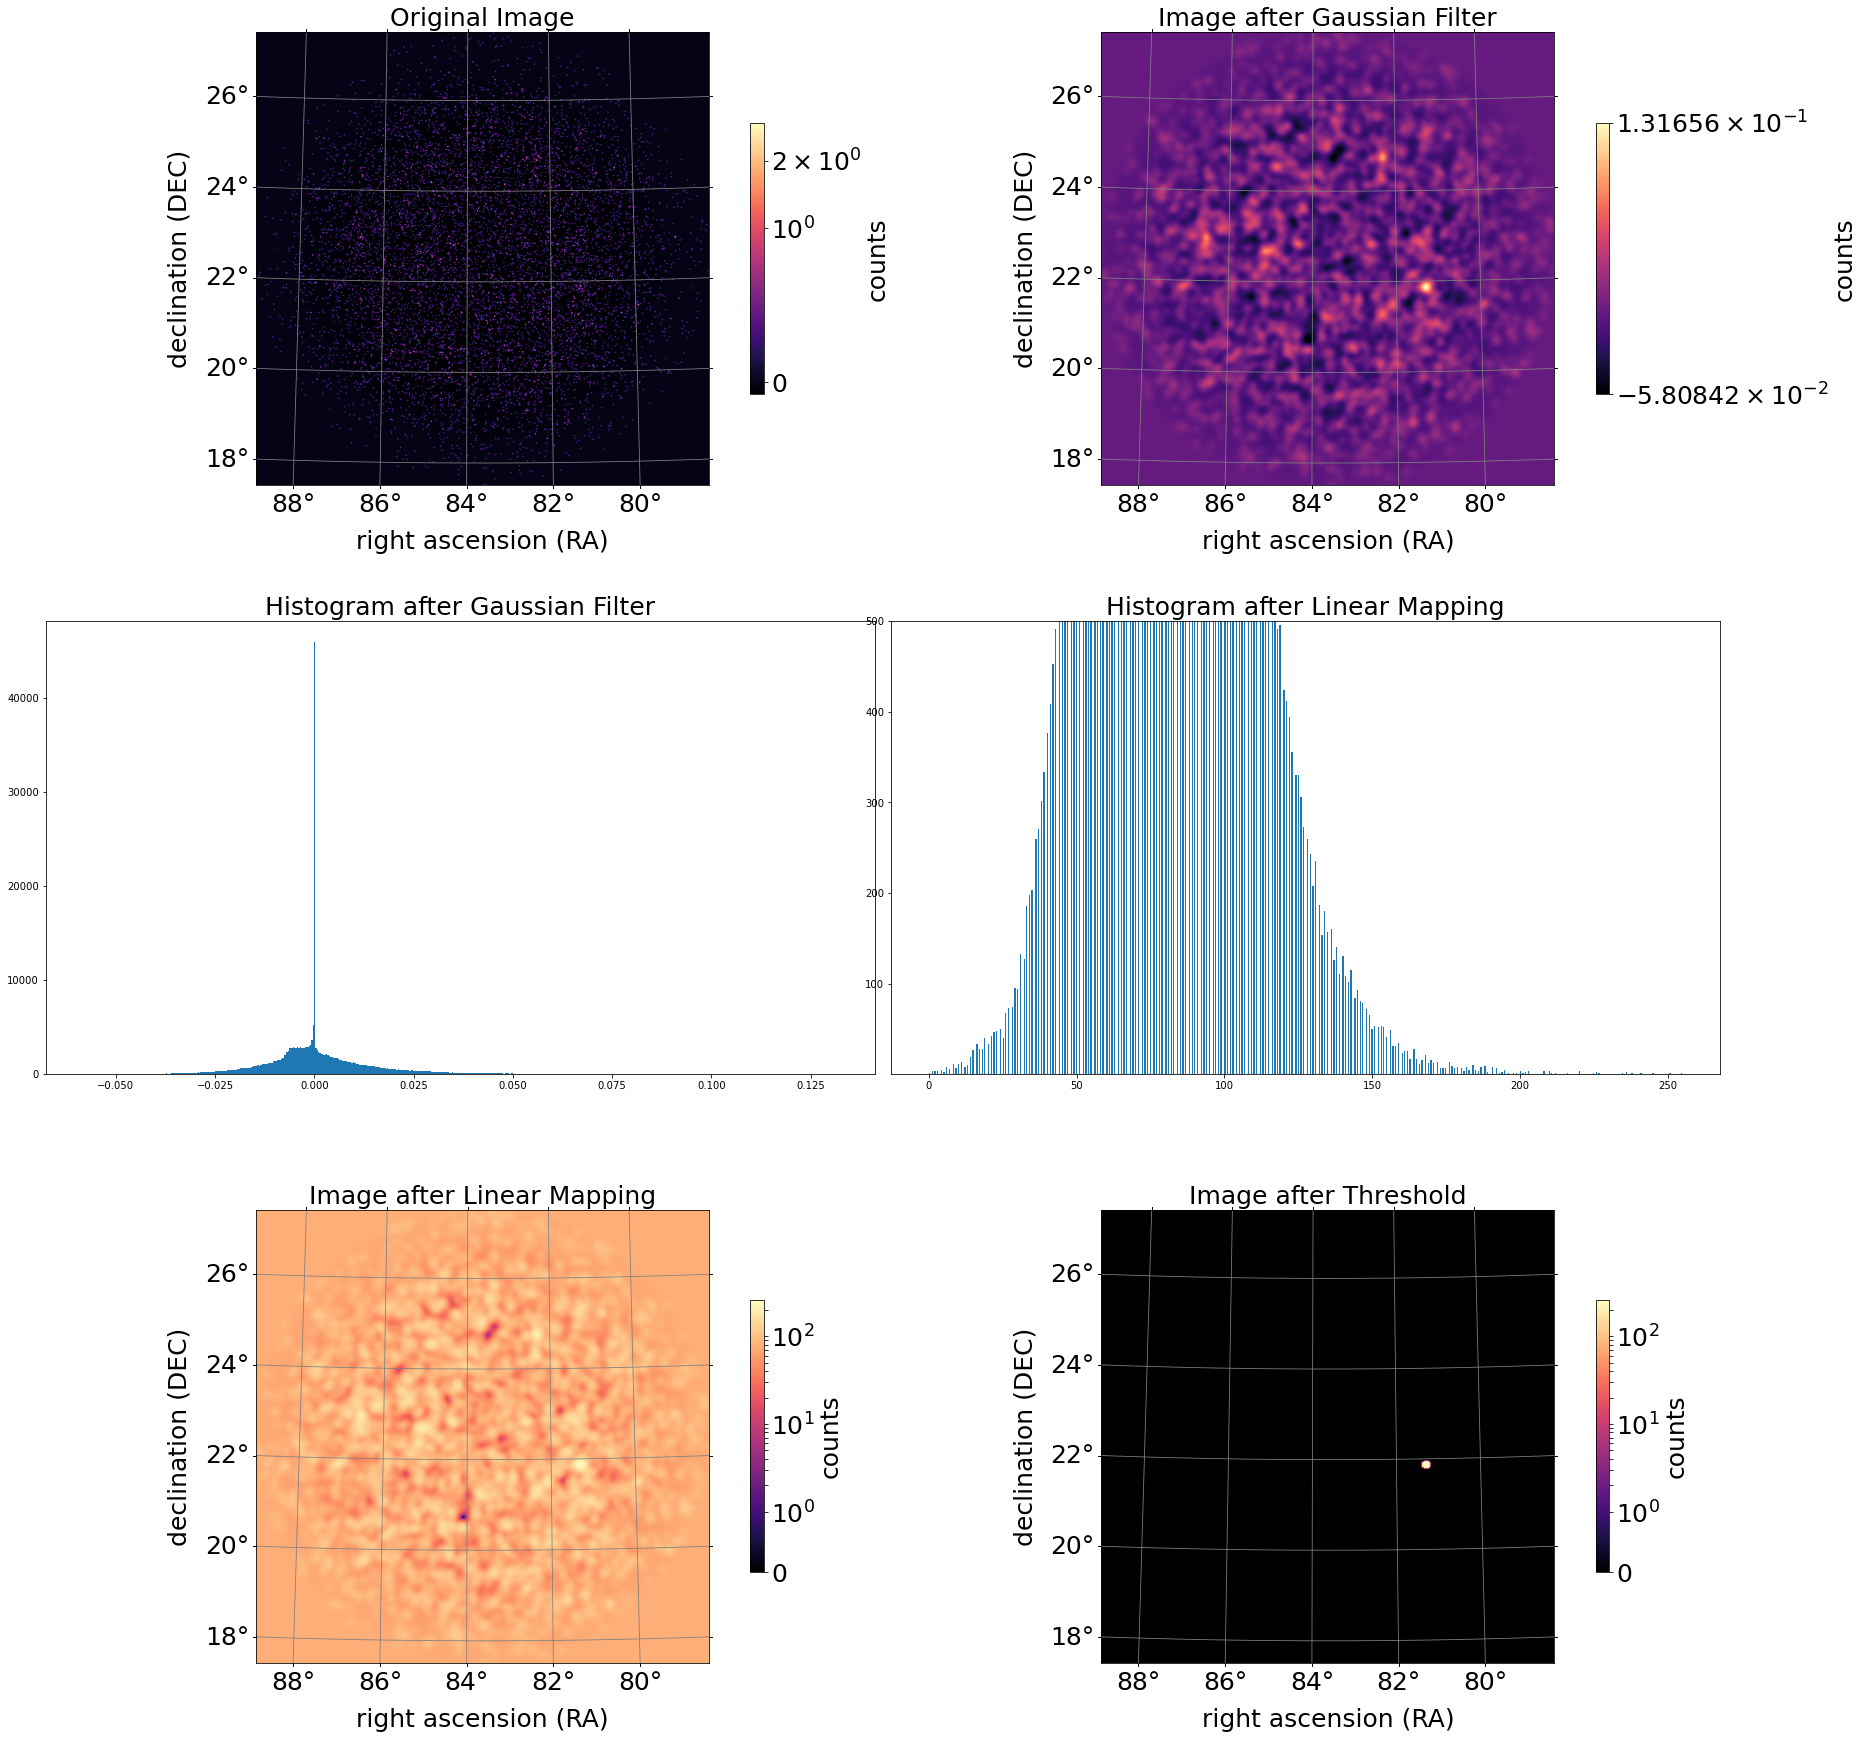



MODEL 159

No source in the image


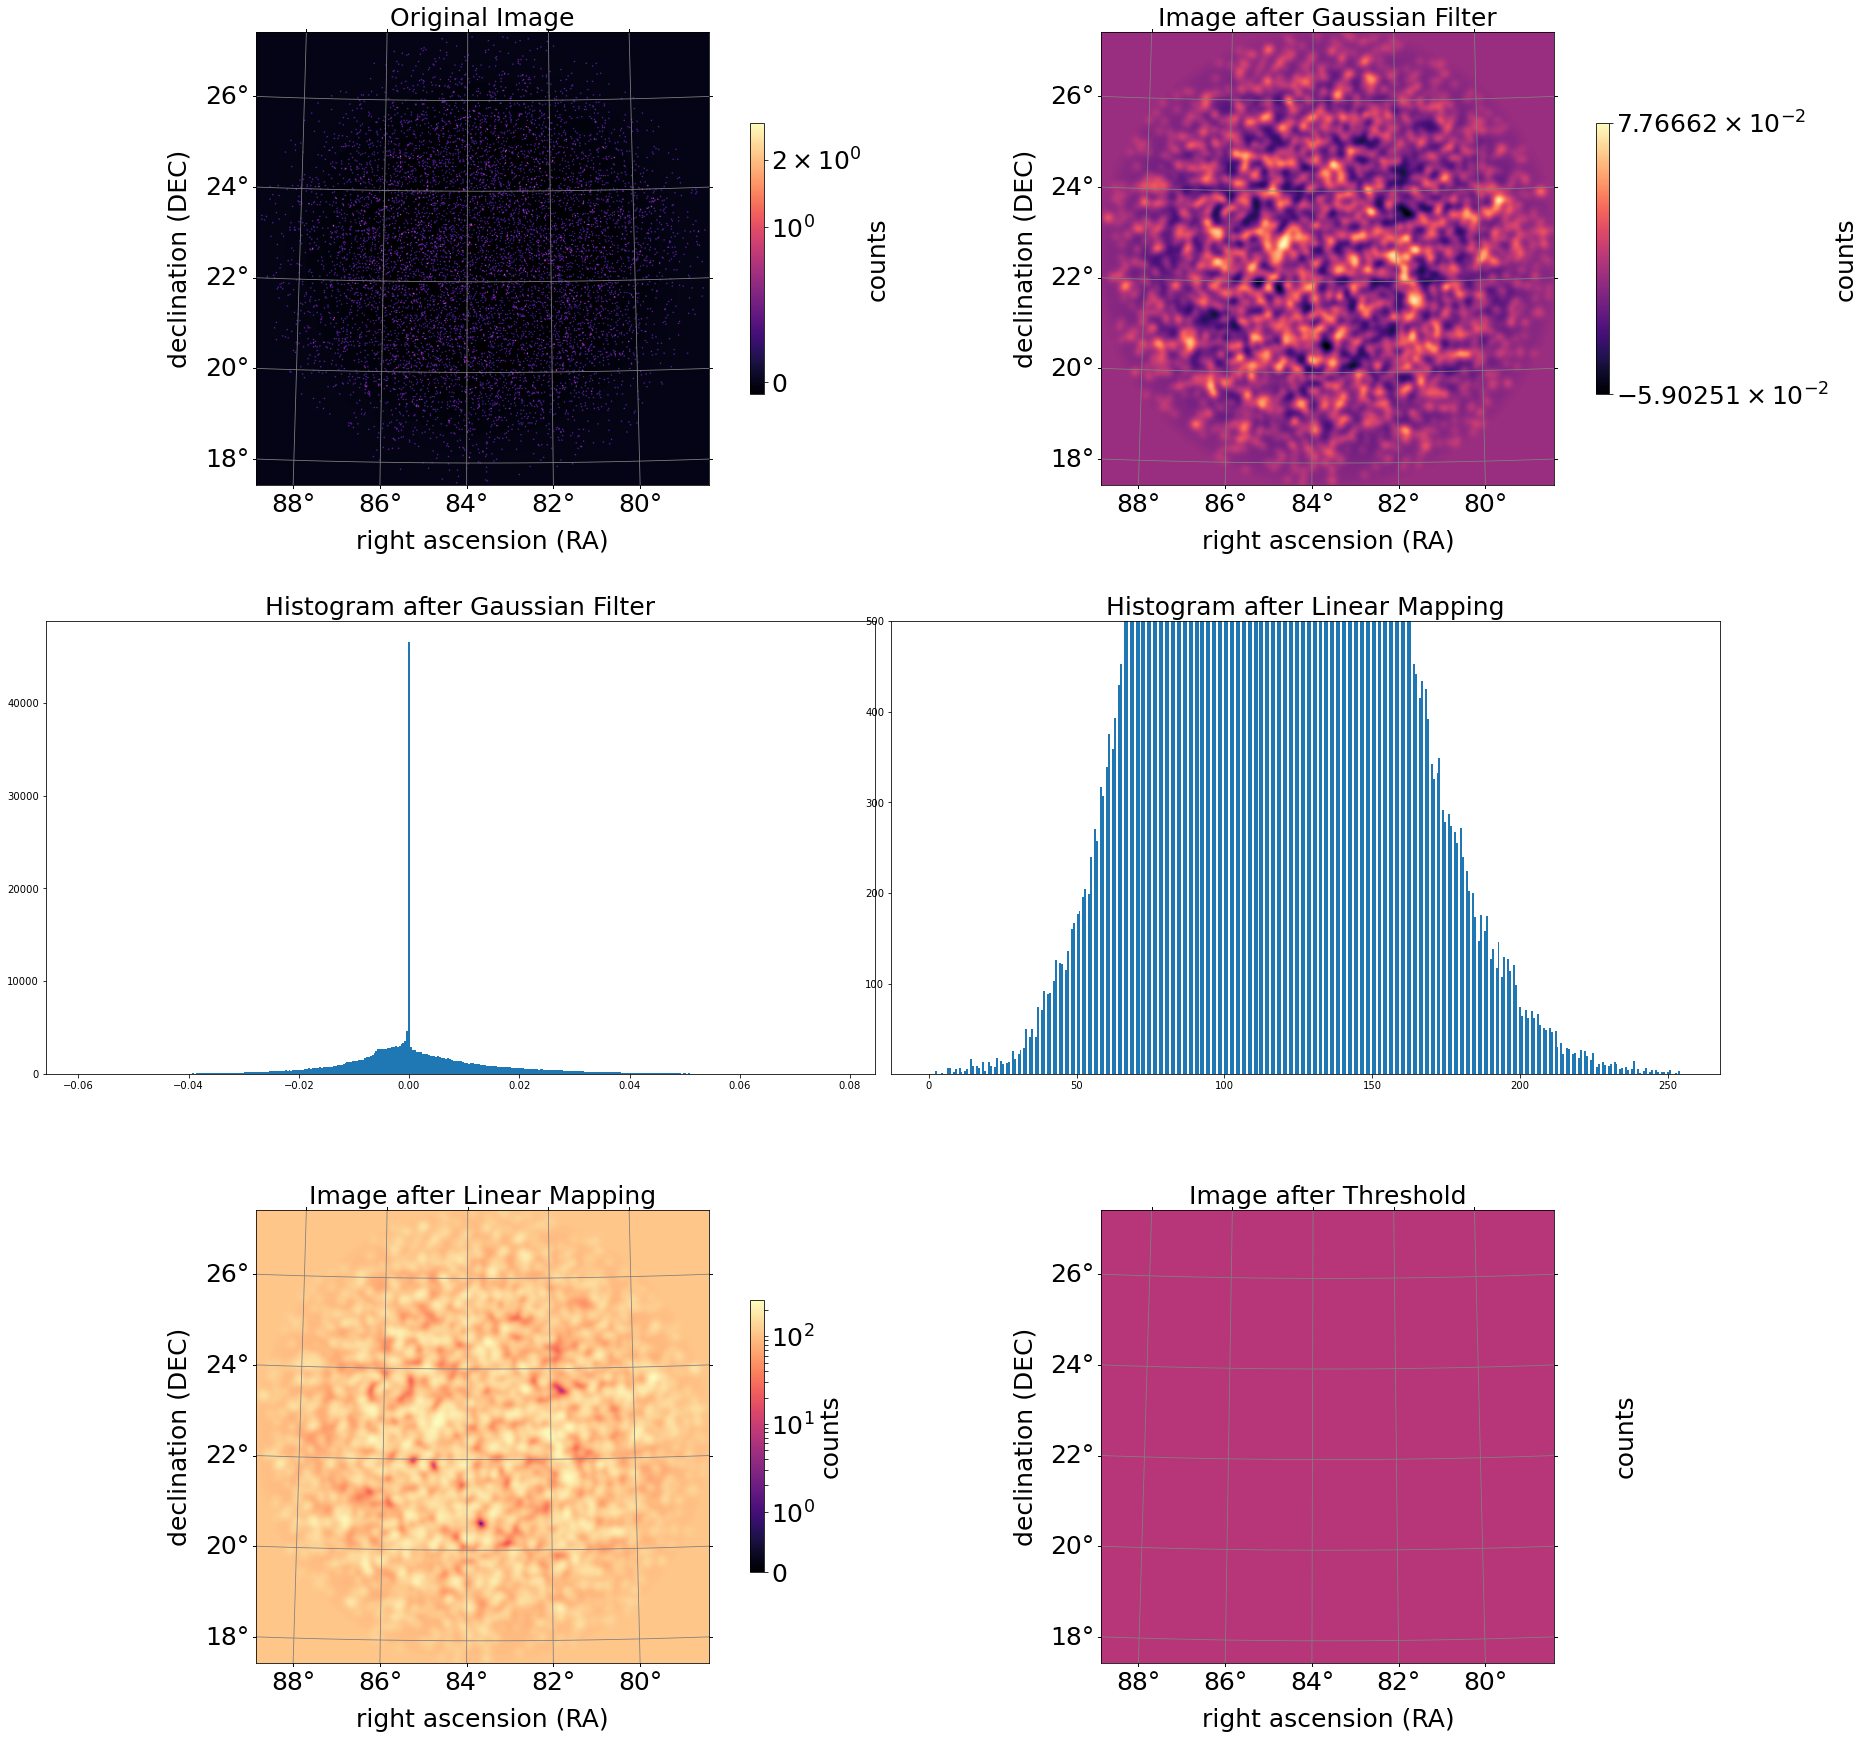



MODEL 341
error:      nan degrees

LABEL 0   	     true coordinates    		   predicted coordinates
degrees:   	   85.84228,    24.59538		        nan,         nan
MODEL 341
error:      nan degrees

LABEL 1   	     true coordinates    		   predicted coordinates
degrees:   	   83.34563,    20.20424		        nan,         nan


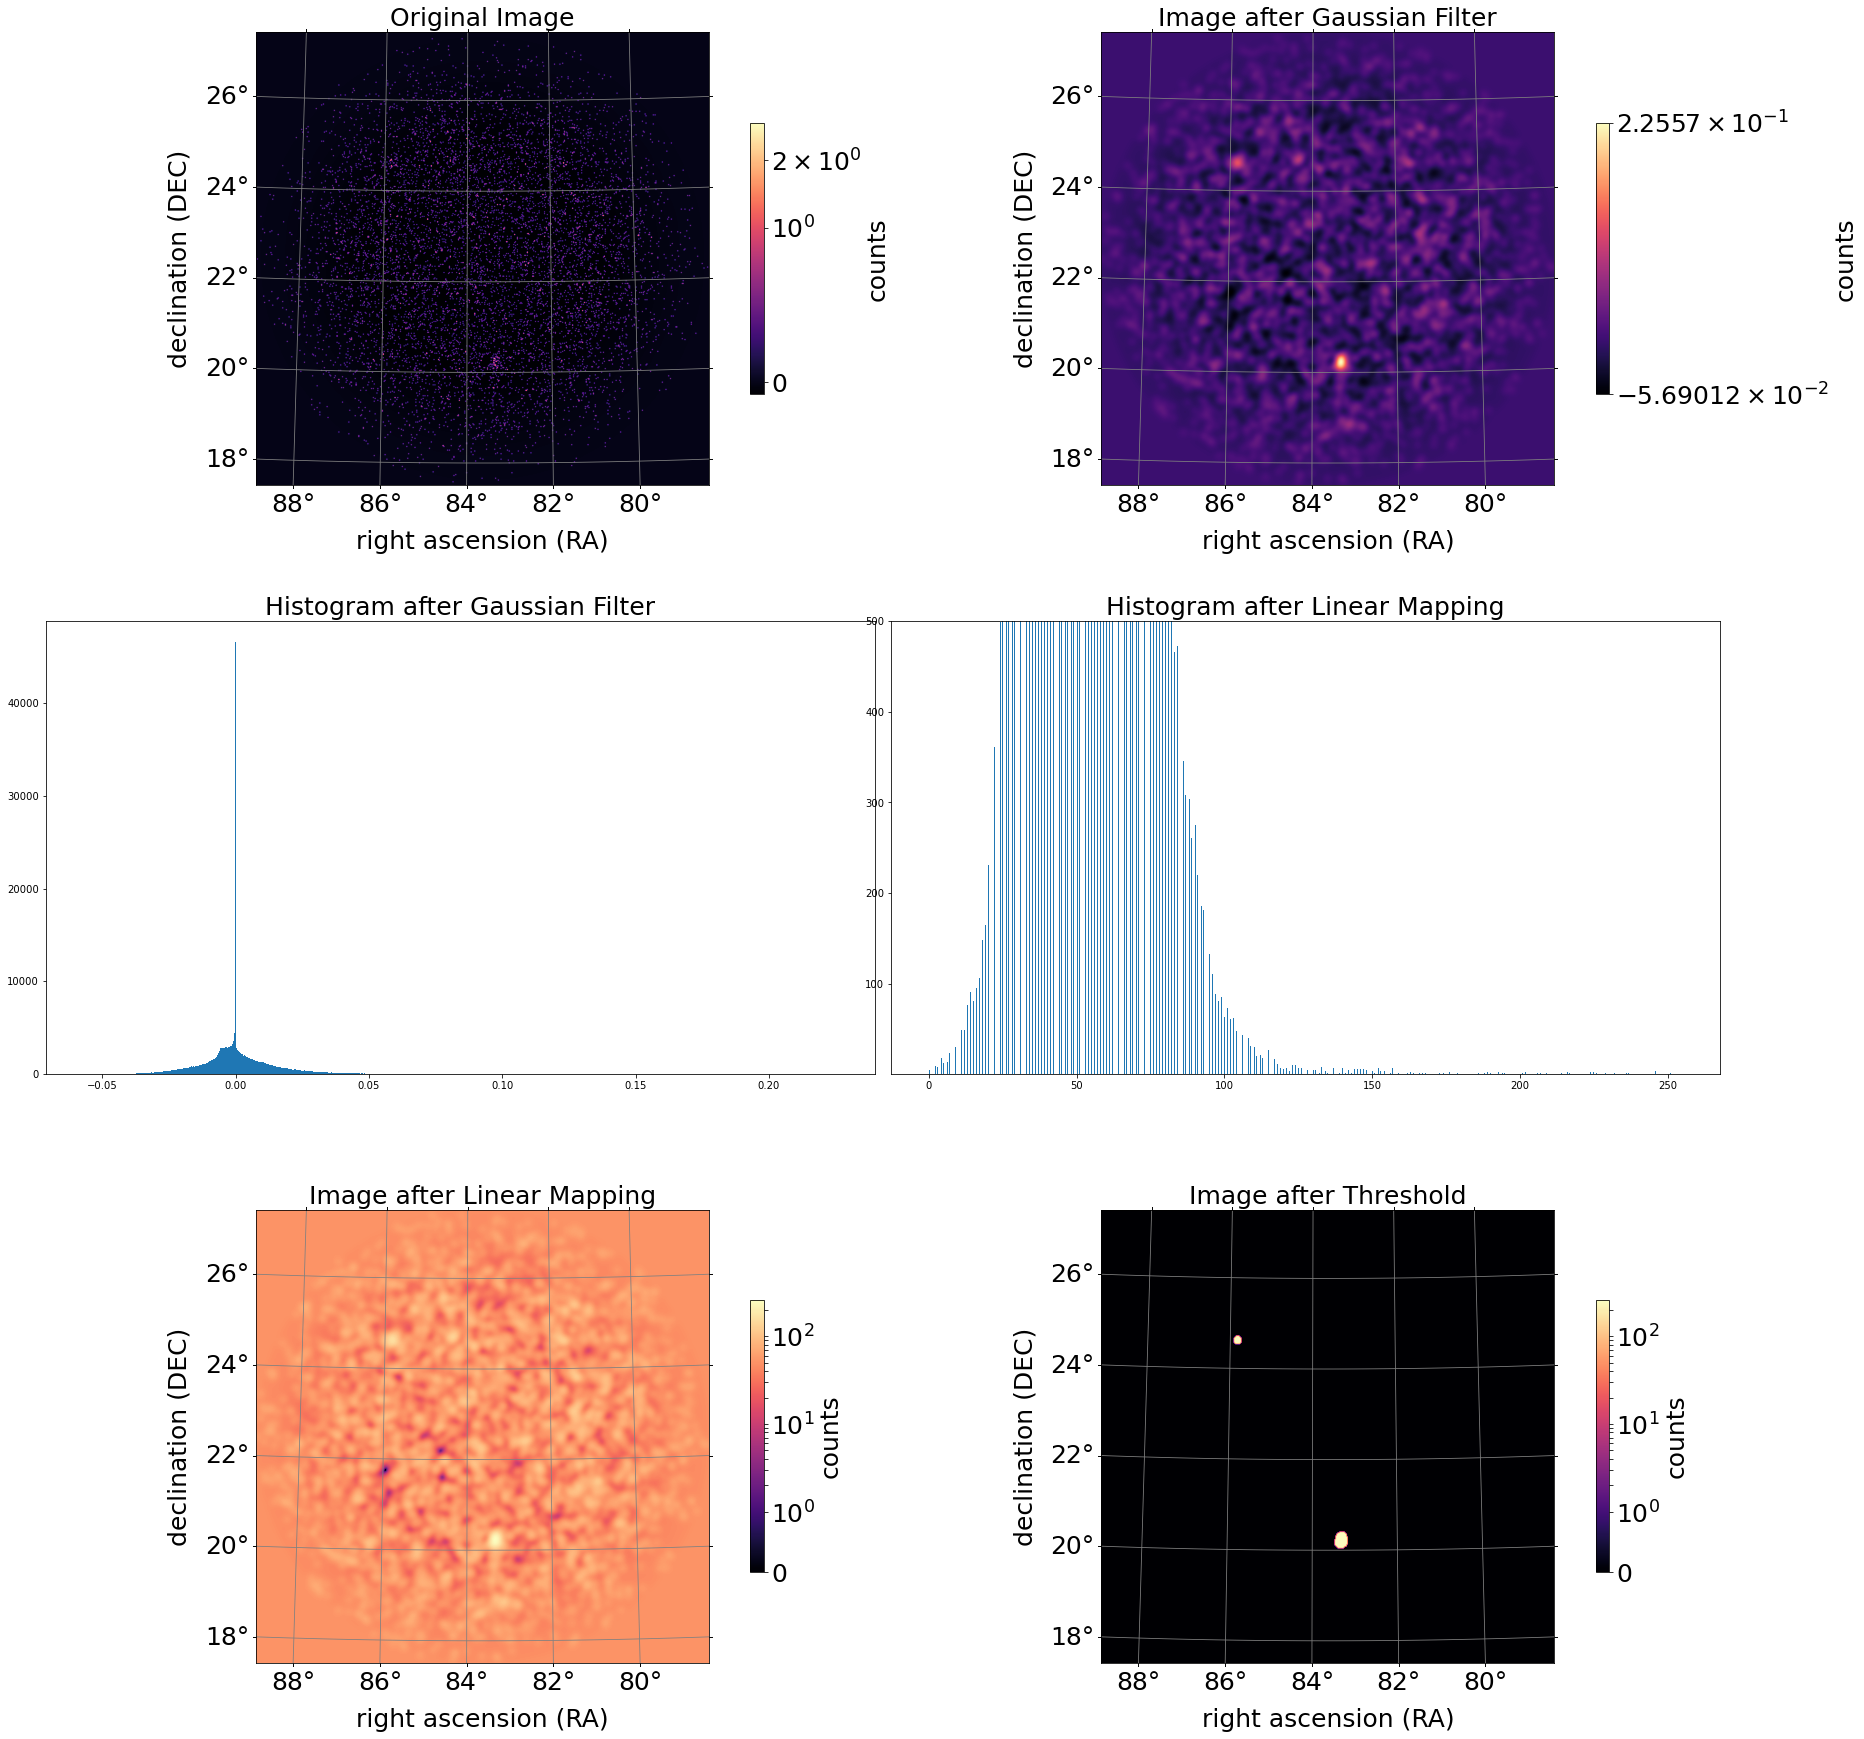

In [12]:
for i in range(0, len(model_selected)):
    algorithm_and_plot(image_concat[i], model_selected[i], font_size)